# Прогнозирование оттока клиента Банка

Из «Бета-Банка» стали уходить клиенты. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.
Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.
Задача - Построем модель с предельно большим значением F1-меры. Дополнительно измерим AUC-ROC, сравним её значение с F1-мерой.

**Описание данных**
Признаки
- `RowNumber` — индекс строки в данных
- `CustomerId` — уникальный идентификатор клиента
- `Surname` — фамилия
- `CreditScore` — кредитный рейтинг
- `Geography` — страна проживания
- `Gender` — пол
- `Age` — возраст
- `Tenure` — сколько лет человек является клиентом банка
- `Balance` — баланс на счёте
- `NumOfProducts` — количество продуктов банка, используемых клиентом
- `HasCrCard` — наличие кредитной карты
- `IsActiveMember` — активность клиента
- `EstimatedSalary` — предполагаемая зарплата

Целевой признак
- `Exited` — факт ухода клиента

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

In [2]:
dataset = pd.read_csv("D:\PY\dsProject1\Churn.csv")
dataset.head(300)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,296,15723654,Tsao,773,France,Male,25,2.0,135903.33,1,1,0,73656.38,0
296,297,15774510,Tien,714,France,Female,31,4.0,125169.26,1,1,1,106636.89,0
297,298,15684173,Chang,687,Spain,Female,44,7.0,0.00,3,1,0,155853.52,1
298,299,15650068,Johnson,511,France,Male,58,0.0,149117.31,1,1,1,162599.51,0


In [3]:
display(dataset.info())
display(dataset.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


None

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

In [4]:
print(dataset['Tenure'].isna().sum()/len(dataset['Tenure']))
dataset['Tenure'] = dataset['Tenure'].fillna(0)

0.0909


Единственный признак, который содержал значительное кол-во нулей - Tenure.Так как этот признак означает кол-во лет, которые клиент является клиентом банка, логично предположить что пустое значение - это 0 лет, поэтому заполняем данные 0.

In [5]:
dataset = dataset.drop(columns = 'CustomerId')
dataset = dataset.drop(columns = 'RowNumber',axis = 1)
dataset = dataset.drop(columns = 'Surname',axis = 1)
dataset

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


Удаляем эти столбцы, так как они никак не влияют на исследуемую задачу(например, имя пользователя)

Воспользуемся техникой OHE, чтобы преобразовать все признаки в количественные.

In [6]:
ohe_dataset = pd.get_dummies(dataset,drop_first=True)

Теперь создадим целевой признак и нецелевые признаки.

In [7]:
features = ohe_dataset.drop('Exited',axis=1)
target = ohe_dataset['Exited']
features

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5.0,0.00,2,1,0,96270.64,0,0,1
9996,516,35,10.0,57369.61,1,1,1,101699.77,0,0,1
9997,709,36,7.0,0.00,1,0,1,42085.58,0,0,0
9998,772,42,3.0,75075.31,2,1,0,92888.52,1,0,1


Теперь разделим на тренировочную тестовую и валидационную в соотношении 3 1 1

In [8]:
features_for_split, features_test, target_for_split, target_test = train_test_split(features, target, test_size=0.2, random_state=12345, stratify=target)

features_train, features_valid, target_train, target_valid = train_test_split(features_for_split, target_for_split, test_size=0.25, random_state=12345, stratify=target_for_split)

## Исследование задачи

Для начала проверим сбалансированность классов.

In [10]:
class_frequency = ohe_dataset['Exited'].value_counts(normalize=True)
class_frequency

0    0.7963
1    0.2037
Name: Exited, dtype: float64

Можем заметить, что положительный класс встречается в 4 раза меньше. Поэтому можно сделать их сбалансированны с помощью upsampling

In [16]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)

    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

# < напишите код здесь >
model = LogisticRegression(solver = 'liblinear',random_state = 12345)
model.fit(features_upsampled,target_upsampled)
predicted_valid = model.predict(features_valid)


print("F1:", f1_score(target_valid, predicted_valid))
class_frequency = target_upsampled.value_counts(normalize=True)
class_frequency

F1: 0.5959183673469388


1    0.561421
0    0.438579
Name: Exited, dtype: float64

Теперь классы сбалансированны, и также подсчитано значение F1. Можно увидеть, что значение F1 не такое большое, хотя мы использовали технику upsampling. Причина в том, что мы не подобрали лучшие гиперпараметры для нашей модели.

In [18]:
 best_f1 = 0
 best_trees = 0
 best_depth = 0
 best_model = None

 for depth in range(1, 30, 1):
     for trees in range(20, 200, 20):
         model = RandomForestClassifier(random_state=12345, n_estimators=trees, max_depth=depth)
         model.fit(features_upsampled, target_upsampled)
         predicted_valid = model.predict(features_valid)
         print(f1_score(target_valid, predicted_valid))
         '''print('Depth:', depth)
         print('Trees:', trees)
         print()'''
         if best_f1 < f1_score(target_valid, predicted_valid):
             best_f1 = f1_score(target_valid, predicted_valid)
             best_depth = depth
             best_trees = trees
             best_model = model
print(best_depth)
print(best_trees)

0.3956945156330087
0.4166211044286496
0.41834451901565994
0.42407509663169524
0.42407509663169524
0.4248878923766816
0.4247787610619469
0.4155844155844155
0.4126473740621651
0.4774647887323943
0.5045180722891566
0.4985207100591716
0.4977973568281938
0.4923968139029689
0.5037481259370316
0.5015015015015015
0.5003756574004509
0.49925705794947994
0.5141545524100994
0.5029940119760479
0.5124716553287981
0.5202492211838006
0.5184049079754601
0.5193199381761978
0.5179526355996945
0.5251742835011619
0.5320665083135392
0.5549915397631133
0.546644844517185
0.5482815057283142
0.5499181669394435
0.5587510271158586
0.5541972290138549
0.5535420098846787
0.5542763157894737
0.5549132947976877
0.562874251497006
0.5594639865996649
0.5587248322147651
0.565
0.5621351125938282
0.5638031693077564
0.5596026490066225
0.5602660016625104
0.5577889447236182
0.5762114537444933
0.5797356828193833
0.5778938207136641
0.5788561525129983
0.5783549783549783
0.5810928013876844
0.5766233766233766
0.578627280625543
0.575

In [19]:
model = RandomForestClassifier(random_state=12345, n_estimators=60, max_depth=11)
model.fit(features_upsampled,target_upsampled)
predicted_valid = model.predict(features_valid)


print("F1:", f1_score(target_valid, predicted_valid))


F1: 0.6287553648068669


После балансирования классов и нахождение лучший гиперпараметров F1 повысилась до 62,это хороший результат.

Построим ROC кривую

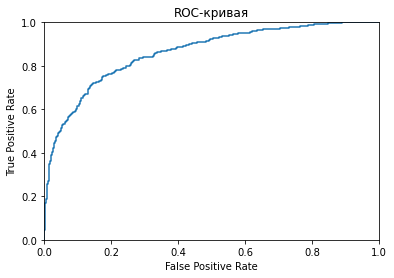

Площадь под кривой ROC составляет: 0.8620978451486926


In [20]:
probabilities_valid = best_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
plt.figure();

plt.plot(fpr, tpr);
plt.xlim([0.0, 1.0]);
plt.ylim([0.0, 1.0]);
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('ROC-кривая');
plt.show()
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('Площадь под кривой ROC составляет:', auc_roc)

Видим, что ROC кривая идет к верхнему правому углу,достаточно высоко. Это значит что качество модели очень хорошее и значение TPR большое.

Теперь применим downsampling.

In [22]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)

    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

# < напишите код здесь >
model = RandomForestClassifier(random_state=12345, n_estimators=60, max_depth=11)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.6003861003861004


Значение F1 не такое большое, как в случае с upsampling, но все же тоже повысилась по сравнению с обучением модели в лоб. Возможно, причиной того что f1 стало меньше может быть то, что размер выборки стал меньше , а значит модель могла недообучиться.

Построим ROC кривуюю

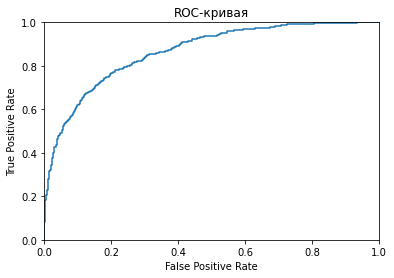

Площадь под кривой ROC составляет: 0.8651270685168992


In [24]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
plt.figure();

plt.plot(fpr, tpr);
plt.xlim([0.0, 1.0]);
plt.ylim([0.0, 1.0]);
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('ROC-кривая');
plt.show()
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('Площадь под кривой ROC составляет:', auc_roc)

ROC значение немного больше чем с увеличенной выборкой.

## Тестирование модели

In [25]:
predicted_test = best_model.predict(features_test)

print('F1 score на тестовой выборке составил:', f1_score(y_true=target_test, y_pred=predicted_test))

F1 score на тестовой выборке составил: 0.6068376068376068


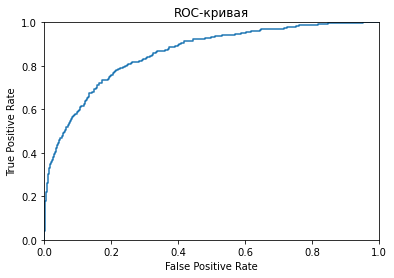

Площадь под кривой ROC составляет: 0.8587786553888248


In [26]:
probabilities_test = best_model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
plt.figure();

plt.plot(fpr, tpr);
plt.xlim([0.0, 1.0]);
plt.ylim([0.0, 1.0]);
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('ROC-кривая');
plt.show()
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('Площадь под кривой ROC составляет:', auc_roc)

In [27]:
features_full_train = pd.concat([features_upsampled, features_valid])
target_full_train = pd.concat([target_upsampled, target_valid])
model = RandomForestClassifier(random_state=12345, max_depth=12, n_estimators=140)
model.fit(features_full_train, target_full_train)
predicted_full_test = model.predict(features_test)
print('F1 score на тестовой выборке из большой выборки составил:', f1_score(y_true=target_test, y_pred=predicted_full_test))

F1 score на тестовой выборке из большой выборки составил: 0.6199524940617577
